<img src="../../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Exercise 2.X Much ado about nothing
<h2 align="center"> Differentiating periods of no-stimulus based behavioral context </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain</h2> 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Astute observers will have noticed that, during the visual behavior task, there are some "omission" trials.

Where most trials include an image, these trials simply omit these expected image in favor of a blank screen. If you recall the results from the workshop, it was very easy to decode these omission stimuli from the responses in visual cortex. This makes a lot of sense; omitting stimuli provides a fundament different visual input to the system, so its no surprise that the visual system would have a very different response. 

Omission trials where not the only time the animal saw a blank screen during these recordings. Each recording includes an unstimulated period of "spontaneous activity," which is just another way of saying that the animal sat in the dark on the rig for a while during the recording. 

Importantly, this means that there were two periods in the recording where the animal saw nothing on its screen - in the first, the animal was expecting to see a stimulus that was withheld, in the other the animal had no such prior. This dichotomy gives us that opportunity to answer an exciting question about the visual system: 

<b> Does this behavioral context/expectation matter for how null-stimuli are represented by the visual system?</b>




<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
In this problem set, we will frame this question as a <b>decoding</b> problem. If there is a difference between these two behavioral epochs, then we should be able to reliably decode which epoch a given snippet of neural activity came from. Just in case you want to go wild with looking at precise timing in your decoding, we will be using the spiking data from the 'visual behavior' dataset.

Here, we will walk through:


<p> 1) Getting data from the omission trials and formatting it in decoder-friendly design matrix
    
<p> 2) Wrangling data from the "spontaneous activity" epoch into a decoder-friendly format. (Hint: we are going to grab snippets that look like trials, even though there is no trial structure here!)
    
<p> 3) Building a decoder for the two epochs, and evaluate its performance using cross validation
        
</div>

In [1]:
# Import some basic packages.
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the AllenSDK 
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

%matplotlib inline

In [2]:
# Find some data!
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"

First, we need to access the data.  This bit should look very similar to this afternoon's workshop

In [3]:
cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)

Grab data from a session

In [4]:
session = cache.get_ecephys_session(
           ecephys_session_id=1065437523) # Feeling brave? Try a different number...

/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Get the stimulus presentations.

In [5]:
stimulus_presentations = session.stimulus_presentations
stimulus_presentations.head(-5)

,stimulus_block,image_name,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,...,rewarded,is_sham_change,temporal_frequency,orientation,position_y,stimulus_index,active,spatial_frequency,position_x,contrast
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,0,im036_r,0.250188,28.131464,28.381652,60,75,False,False,False,...,False,False,NaN,NaN,NaN,-99,True,NaN,NaN,NaN
1,0,im036_r,0.250188,28.882028,29.132216,105,120,False,False,False,...,False,False,NaN,NaN,NaN,-99,True,NaN,NaN,NaN
2,0,im036_r,0.250232,29.632680,29.882912,150,165,False,False,False,...,False,False,NaN,NaN,NaN,-99,True,NaN,NaN,NaN
3,0,im036_r,0.250186,30.383329,30.633515,195,210,False,False,False,...,False,False,NaN,NaN,NaN,-99,True,NaN,NaN,NaN
4,0,im036_r,0.250229,31.133886,31.384115,240,255,False,False,False,...,False,False,NaN,NaN,NaN,-99,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13381,5,im047_r,0.250210,8776.735046,8776.985256,522677,522692,False,False,False,...,False,False,NaN,NaN,NaN,-99,False,NaN,NaN,NaN
13382,5,im047_r,0.250207,8777.485673,8777.735881,522722,522737,False,False,False,...,False,False,NaN,NaN,NaN,-99,False,NaN,NaN,NaN
13383,5,im047_r,0.250208,8778.236296,8778.486503,522767,522782,False,False,False,...,False,False,NaN,NaN,NaN,-99,False,NaN,NaN,NaN


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">


<b>
1) Getting data from the omission trials and formatting it in decoder-friendly design matrix
    

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b> (1a) Get the start and end times of omission stimuli </b>

Using the stimulus table, get the start and end time of the omission trials

Hint: they are stored as "omitted" in the image name

In [6]:
omission_start = stimulus_presentations.start_time[stimulus_presentations.image_name== 'omitted'].values
omission_end = stimulus_presentations.end_time[stimulus_presentations.image_name== 'omitted'].values

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b> (1b) Filter spiketrains for an area</b>

VISP/V1 is always a favorite to start

In [7]:
session_unit_info = session.get_units()
session_channel_info = session.get_channels()


spike_times = {}
for ii in range(len(session_unit_info)):
    this_unit = session_unit_info.index.values[ii]
    if session_unit_info.quality.values[ii] != 'good':
        continue
    max_channel = session_unit_info.peak_channel_id.values[ii]
    if session_channel_info[session_channel_info.index == max_channel].structure_acronym.values[0] == 'VISp':
        spike_times[this_unit] = session.spike_times[this_unit]


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b> (1b) Use these timestamps to build a matrix with the spike counts for each omission </b>

Your matrix will be be of size '# of omissions' x '# units'

In [8]:

# Function for getting spike counts in a specified window
def get_trial_spike_rates(spikes, startTimes, endTimes):
    rates = np.zeros(len(startTimes))
    for i,start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, endTimes[i])
        rates[i] =np.count_nonzero(spikes[startInd:endInd])/(endTimes[i]-start)

    return rates


In [9]:
N = len(spike_times.keys())
omission_spike_rates = np.zeros((len(omission_start),N,))

for ii,key in enumerate(spike_times.keys()):
    omission_spike_rates[:,ii]= get_trial_spike_rates(spike_times[key], omission_start, omission_end)



<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b> (2) Wrangling data from the "spontaneous activity" epoch into a decoder-friendly format. </b>


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b> (2a) Find the start and stop times of spontainous activity </b>

They are stored in the stimulus_presentations table with `stimulus_name`=='spontaneous'. In this case, lets just use longest interval.


In [10]:
spont_start = stimulus_presentations[stimulus_presentations.stimulus_name=='spontaneous'].start_time.values[1]
spont_end = stimulus_presentations[stimulus_presentations.stimulus_name=='spontaneous'].end_time.values[1]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b> (2b) Build a trails matrix (similar to the one above) for spontaneous activity </b>

But wait! Spontaneous activity doesn't have a trial structure. 

For now, our solution will be to randomly grab population activity during time intervals equivalent to those of omission activity. 

Create a `spont_spike_rates` matrix equivalent to the one we built above, but with trails randomly extracted from the spontanious trial block.


In [11]:
# Length of spontaneous activity
spont_length = spont_end - spont_start

# Storage vectors
psuedo_trial_start = np.zeros(omission_start.shape)
psuedo_trial_end = np.zeros(omission_end.shape)


for ii in range(psuedo_trial_start.shape[0]):
    # Get an equivalent trial to the current trial length
    comp_trial_length = omission_end[ii]-omission_start[ii]
    # Get a fake start time for our 'psuedo trial' that is within the spontaneous activity
    psuedo_trial_start[ii] = spont_start + np.random.rand()*(spont_length-comp_trial_length)
    psuedo_trial_end[ii] = psuedo_trial_start[ii] + comp_trial_length

In [12]:
spont_spike_rates = np.zeros((len(psuedo_trial_start),N,))

for ii,key in enumerate(spike_times.keys()):
    spont_spike_rates[:,ii]= get_trial_spike_rates(spike_times[key], psuedo_trial_start, psuedo_trial_end)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b> (2c) Combine your rates into a decoder-friendly format </b>

Generate stack your rates into a single `X` matrix. Generate `y` matrix that contains a 0 value for omissions trials and 1 for spontaneous activity.

In [13]:
X = np.concatenate((omission_spike_rates,spont_spike_rates),axis=0)
y = np.concatenate((np.zeros(omission_spike_rates.shape[0]),np.ones(spont_spike_rates.shape[0])))   


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>
<p> 3) Building a decoder for the two epochs, and evaluate its performance using cross validation


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>
<p> 3a) Import what you need for a decoder and cross validation
</b>

You can use a Linear Support Vector Machine like we did in this mornings workshop if you like, but feel free to try out some of the other decoders in `sklearn`. Once you code is working, you might even think about comparing linear and non-linear decoders :)

In [14]:
from sklearn import svm

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>
<p> 3b) Train your decoder and evaluate with cross validation.  
</b>

How did we do?



In [ ]:
# Hint:
from sklearn.model_selection import StratifiedKFold

In [15]:
folderizer = StratifiedKFold(n_splits=5, shuffle=True)

for (train_index, test_index) in folderizer.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = svm.SVC(kernel='linear')
    clf.fit(X_train, y_train)
    print(clf.score(X_test, y_test))


0.8863636363636364
0.8931297709923665
0.8244274809160306
0.9083969465648855
0.9083969465648855


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>
<p> 3c) What can we actually learn from this?
</b>

<p>
How well did your decoder do? 
<p>
Given that the visual stimulus was the same between conditions, is this what you expected? What does this tell you about information in V1? Do you see any caveats that need to be controlled for?

<p>
For starters, try comparing the average firing rate of each cell in each instance. You can use `np.mean(rate_matrix,axis=0)` for this, or you can be really fancy and fit linear regression models (here they turn out to be the same!).



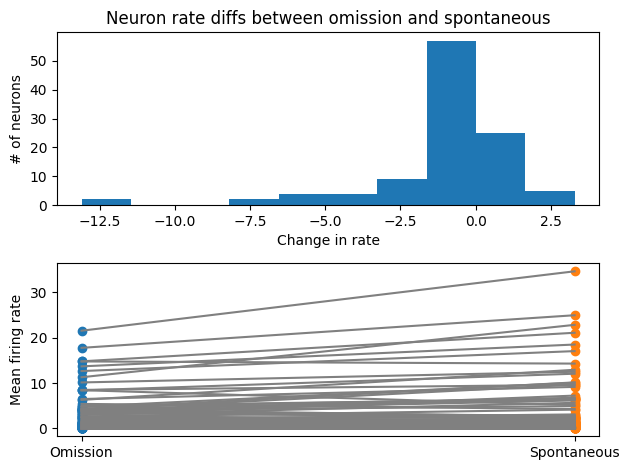

In [16]:
fig,ax = plt.subplots(nrows= 2)
ave_omission_rate = np.mean(omission_spike_rates,axis=0)
ave_spont_rate = np.mean(spont_spike_rates,axis=0)

ax[0].hist(ave_omission_rate-ave_spont_rate)
ax[0].set_xlabel('Change in rate')
ax[0].set_ylabel('# of neurons')
ax[0].set_title('Neuron rate diffs between omission and spontaneous')

ax[1].scatter(np.zeros(N),np.mean(omission_spike_rates,axis=0))
ax[1].scatter(np.ones(N),np.mean(spont_spike_rates,axis=0))
for ii in range(N):
    ax[1].plot([0,1],[ave_omission_rate[ii],ave_spont_rate[ii]],color='grey')   
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(['Omission','Spontaneous'])
ax[1].set_ylabel('Mean firing rate')

fig.set_tight_layout(True)




<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>
<p> 4) Explore!!  
</b>

Now that you have a basic decoder framework for this question, feel free to have some fun selecting out questions. Who knows, you might end up with some fun project ideas.

Some starter ideas include (but are not limited to):

- What happens if you select different brain areas. Are they the same? Think about comparing e.g. a cortical sensory area (like VISp) to thalamic (LGd) and "Higher order" areas. What differences do you see?
- How important is the timescale of this difference - Do you results change in the later or earlier parts of the omissions trials?
- What if we had separated passive and active phases of the task? or times when the mouse disengages? Would this change some answers?
- What if you include/exclude particular cell types from your analysis?


